# Previsão de Churn - Aprendizado de Máquina

**Churn**, também chamado de *churn rate* ou *attrition rate*, é uma métrica que mede a evasão de clientes de determinada empresa, ou seja, a taxa de cancelamento. Ou seja, caso a taxa de evasão seja alta, quer dizer que os clientes estão insatisfeitos com a empresa, e que há algum problema que deve ser tratado. Nesse caso, o notebook trata de um dataset fictício de um banco visando previsão de churns.

### O problema de negócio
O [Dataset](https://www.kaggle.com/mervetorkan/churndataset?select=churn.csv) apresenta 10.000 instâncias com dados fictícios de um banco que atua na Europa, com 14 atributos diversos acerca de clientes como nome, pontuação de crédito, salário estimado, se possui ou não cartão de crédito, entre outros, e por fim, se existiu evasão ou não por parte do cliente i.e. churn. 

A taxa média de churn é claramente variável de acordo com o porte e segmento da empresa. No caso do setor bancário, taxas de churn entre 11% a 34% podem ser encontradas [[1]](https://thefinancialbrand.com/59779/digital-banking-branch-channel-switching/). Partindo desse princípio, o notebook apresenta um modelo de aprendizado de máquina de previsão de churn utilizando o dataset pré-processado.

- Importar bibliotecas:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings as wn

wn.filterwarnings('ignore')

plt.style.use('ggplot')

- Ler o dataset, mostrar as 5 primeiras linhas:

In [33]:
df = pd.read_csv('churn_preprocessing.csv', index_col='CustomerId')

In [34]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,Germany_Balance
CustomerId,,,,,,,,,
15634602,619,42,2,0.00,1,1,101348.88,1,0
15647311,608,41,1,83807.86,1,1,112542.58,0,0
15619304,502,42,8,159660.80,3,0,113931.57,1,0
15701354,699,39,1,0.00,2,0,93826.63,0,0
15737888,850,43,2,125510.82,1,1,79084.10,0,0


# 1 - Pré-processamento

- Split dataset em treino e teste:

In [6]:
from sklearn.model_selection import train_test_split

In [35]:
X = df.drop('Exited', axis=1)
y = np.array(df['Exited'])

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [37]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7000, 8), (3000, 8), (7000,), (3000,))

- Normalizar o dataset ($\mu$=0 e $\sigma$=1):

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

In [39]:
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

# 2 - Aprendizado de Máquina

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve

As métricas de avaliação dos modelos foram:

- Precision: de todos os clientes que o modelo previu churn, quantos deles realmente saíram?
$$ Precision = \frac{TP}{(TP+FP)} $$


- Recall: % de clientes previstos para churn que o modelo previu corretamente?
$$ Recall = \frac{TP}{(TP+FN)}$$


- F1: medida relativa de precision e recall (média harmônica):
$$ F_1 = \frac{TP}{(TP + \frac{1}{2}(FP+FN))}$$


- ROC-AUC: relação entre taxas de TP e FP, sendo que a AUC (área sob a curva) sumariza a ROC em um único número (quão mais próxima de 1, melhor o classificador em relação á taxa de falso positivos).

onde TP$\to$true positive, FP$\to$false positive (erro tipo I), e TN$\to$false negative (erro tipo II)

### Avaliação em função do problema de negócio




A priori, temos como resultado do modelo de classificação a matriz de confusão, que apresenta os seguintes valores:

- TP: previsão de churn, que realmente ocorre $\to$ perda monetária pois cliente sai
- TN: previsão de não churn, que realmente ocorre $\to$ sem perda monetária, pois cliente permanece
- FP: previsão de churn, mas cliente não sai $\to$ sem perda monetária, pois cliente permanece
- FN: previsão de não churn, mas cliente sai $\to$ perda monetária, pois previu que cliente ficaria e ele saiu

Até tal ponto, é possível compreender as previsões, porém não dentro de um contexto de negócio. Faz-se necessário então aplicar um conceito bastante utilizado onde pode-se concatenar as previsões do modelo de aprendizado de máquina com valores do negócio - conceito de **valor esperado**:

$$EV = p(o_1)v(o_1) + p(o_2)v(o_2) + ...$$

onde $p(o_i)$ é a probabilidade do evento, e $v(o_i)$ é seu valor.

Nesse contexto, visando calcular o valor esperado de lucro de uma campanah de retenção de clientes, pode-se realizar uma análise de curso-benefício, onde temos TP e TN como benefícios (modelo previu corretamente), e FP e FN como os custos (modelo previu incorretamente). A matriz de custo-benefício utilizada para avaliação do projeto, com valores fictícios retirados de [[2]](http://rstudio-pubs-static.s3.amazonaws.com/277278_427ca6a7ce7c4eb688506efc7a6c2435.html), com as mesmas dimensões da matriz de confusão do modelo, foi:

- TP $\to$ benefício $\to$ $1000 - cliente responde positivamente à campanha e tinha intenção de churn

- TN $\to$ benefício $\to$ $50 - cliente não recebe a campanha pois não tinha intenção de churn, e continua contribuindo

- FP $\to$ custo $\to$ -$250 - cliente responde positivamente à campanha, mas não tinha intenção de churn

- FN $\to$ custo $\to$ -$2000 - cliente não responde positivamente à campanha e churn

Entretanto, é importante também levar em consideração a probabilidade de se encontrar cada classe *a priori*, ou seja, a probabilidade *a priori* de ocorrer churn ou não [[3]](https://www.oreilly.com/library/view/data-science-for/9781449374273/), ou seja, $p(0)$ ou $p(ñ churn)$ e $p(1)$ ou $p(churn)$. Assim, temos que:

$$EV_{profit} = p(1)*[p(Y|1)b(Y,1) + p(N|1)c(N,1)] + $$
$$p(0)*[p(N|0)b(N,0) + p(Y|0)c(Y,0)] $$

onde:
- p $\to$ probabilidade
- b e c $\to$ benefício e custo
- 0 e 1 $\to$ não churn e churn
- N e Y $\to$ previsão de não churn e churn

O valor esperado de lucro pode ser expresso, portanto, como:

$$EV_{profit} = 0.2037*[1000p(Y|1) - 2000p(N|1)] + 0.7963*[50p(N|0) - 250p(Y|0)] \to$$

$$\to EV_{profit} = 203.7p(Y|1) + 39.815p(N|0) - 407.4p(N|1) - 199.075p(Y|0) $$

Nota-se, portanto, que FP tendem a reduzir fortemente o valor esperado. Nesse caso, é importante compreender como a matriz de custo-benefício pode influenciar no valor esperado de lucro.

Entretanto, como existe um trade-off entre precision e recall, os modelos foram treinados utilizando-se como score a métrica F1, média harmônica entre as métricas mencionadas, a qual apresentou os melhores resultados de valor esperado com o algoritmo SVM.

In [40]:
# matriz de custo-benefício
cb = np.array([[50,-250],[-2000, 1000]])
              
pd.DataFrame(np.array([[50,-250],[-2000, 1000]]), index=['True_0','True_1'], 
             columns=['Pred_0','Pred_1'])

,Pred_0,Pred_1
True_0,50,-250
True_1,-2000,1000


In [41]:
# probabilidade de churn e não churn
p_0 = df.query('Exited==0').shape[0]/df.shape[0]
p_1 = df.query('Exited==1').shape[0]/df.shape[0]
p_0, p_1

(0.7963, 0.2037)

### 2.1 - Baseline: Naïve Bayes

Utilização de um classificador Naïve Bayes como baseline. Pode ser visto que o classificador é pouco que um classificador majoritário pelos resultados da matriz de confusão normalizada e curva ROC-AUC, onde o classificador acertou 97% da classe majoriatária, e classificou 92% da classe minoritária como majoritária, atingindo uma AUC de 0.72.

In [15]:
from sklearn.naive_bayes import GaussianNB

In [42]:
# Naïve Bayes
nb = GaussianNB()

nb.fit(x_train, y_train)

GaussianNB()

In [43]:
# predição
nb_predict = nb.predict(x_test)

In [44]:
# métricas de comparação
print('Precision:',precision_score(y_test, nb_predict))
print('Recall:',recall_score(y_test, nb_predict))
print('F1:',f1_score(y_test, nb_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, nb_predict))

Precision: 0.38345864661654133
Recall: 0.08121019108280254
F1: 0.7192686095230547
ROC-AUC: 0.5233201039731045


In [45]:
# matriz de confusão
nb_cm = confusion_matrix(y_test, nb_predict, normalize='true')
pd.DataFrame(confusion_matrix(y_test, nb_predict))

,0,1
0,2290,82
1,577,51


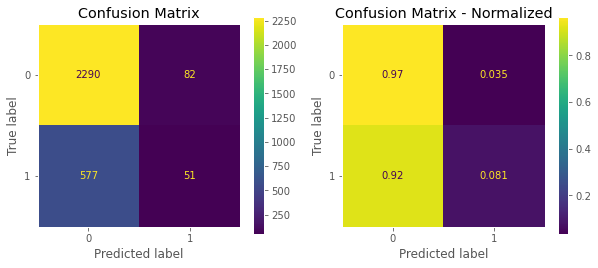

In [46]:
# matriz de confusão
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_confusion_matrix(nb, x_test, y_test, ax=ax[0])
ax[0].grid(False)
ax[0].set(title='Confusion Matrix')
plot_confusion_matrix(nb, x_test, y_test, normalize='true',ax=ax[1])
ax[1].grid(False)
ax[1].set(title='Confusion Matrix - Normalized');

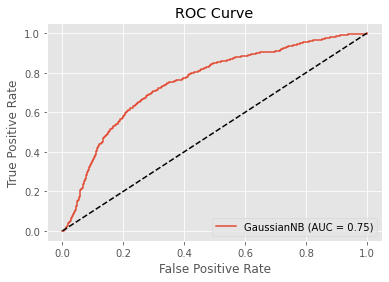

In [47]:
# curva ROC
plot_roc_curve(nb, x_test, y_test)
plt.title('ROC Curve')
plt.plot(np.linspace(0,1,50), np.linspace(0,1,50), linestyle='--', color='k');

### 2.2 - Regressão Logística

A regressão logística é uma técnica estatística que tem como objetivo produzir, a partir de um conjunto de observações, um modelo que permita a predição de valores tomados por uma variável categórica, frequentemente binária, a partir de uma série de variáveis explicativas, sendo um modelo de fácil explicação e rápido.

In [22]:
from sklearn.linear_model import LogisticRegression

In [48]:
# parâmetros para random search
C = [0.001, 0.01, 0.1, 1, 10, 100]
solver = ['newton-cg','liblinear','lbfgs']
penalty = ['l1','l2']
params = dict(C=C, solver=solver, penalty=penalty)

# classificador
clf = LogisticRegression(class_weight='balanced', random_state=42)

# search
kfold = KFold(n_splits=10, random_state=42)
search = RandomizedSearchCV(clf, 
                            params, 
                            scoring='f1', 
                            cv = kfold,
                            n_jobs=-1, 
                            verbose=1).fit(x_train_sc, y_train)

# avaliar parâmetros
search.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished


{'solver': 'liblinear', 'penalty': 'l2', 'C': 100}

In [49]:
# modelo
lr = LogisticRegression(solver='liblinear',C=100,penalty='l2',
                        class_weight='balanced',random_state=42,n_jobs=-1)

lr.fit(x_train_sc, y_train)

LogisticRegression(C=100, class_weight='balanced', n_jobs=-1, random_state=42,
                   solver='liblinear')

In [50]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
lr_results = cross_val_score(lr, x_train_sc, y_train, cv = kfold, scoring='f1')
lr_results.mean()

0.49009697181035794

In [51]:
# predição
lr_predict = lr.predict(x_test_sc)

In [52]:
# métricas
print('Precision:',precision_score(y_test, lr_predict))
print('Recall:',recall_score(y_test, lr_predict))
print('F1:',f1_score(y_test, lr_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, lr_predict))

Precision: 0.3888404533565824
Recall: 0.7101910828025477
F1: 0.7306193827263384
ROC-AUC: 0.7073299427503464


In [53]:
# matriz de confusão
lr_cm = confusion_matrix(y_test, lr_predict, normalize='true')
pd.DataFrame(confusion_matrix(y_test, lr_predict))

,0,1
0,1671,701
1,182,446


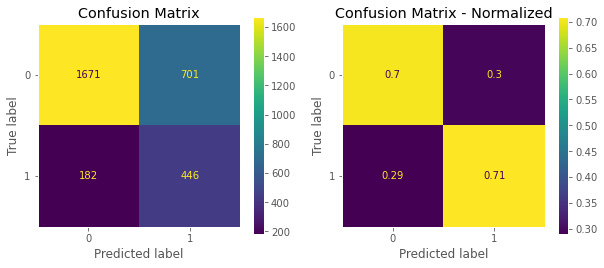

In [54]:
# matriz de confusão
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_confusion_matrix(lr, x_test_sc, y_test, ax=ax[0])
ax[0].grid(False)
ax[0].set(title='Confusion Matrix')
plot_confusion_matrix(lr, x_test_sc, y_test, normalize='true',ax=ax[1])
ax[1].grid(False)
ax[1].set(title='Confusion Matrix - Normalized');

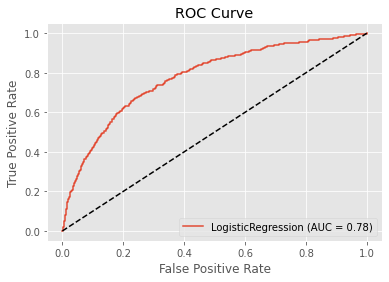

In [55]:
# curva ROC
plot_roc_curve(lr, x_test_sc, y_test)
plt.title('ROC Curve')
plt.plot(np.linspace(0,1,50), np.linspace(0,1,50), linestyle='--', color='k');

### 2.3 - SVM

In [31]:
from sklearn.svm import SVC

In [56]:
# parâmetros para random search
C = [0.1, 1, 10, 100]
kernel = ['rbf']
gamma = [0.001, 0.01, 0.1, 1]
params = dict(C=C, gamma=gamma, kernel=kernel)

# classificador
clf = SVC(class_weight='balanced', random_state=42)

# search
kfold = KFold(n_splits=10, random_state=42)
search = RandomizedSearchCV(clf, 
                            params, 
                            scoring='f1',
                            cv=kfold,
                            n_jobs=-1, 
                            verbose=1).fit(x_train_sc, y_train)

# avaliar parâmetros
search.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


{'kernel': 'rbf', 'gamma': 0.1, 'C': 1}

In [57]:
# modelo
svm = SVC(kernel='rbf',gamma=0.1,C=1,class_weight='balanced',random_state=42)

svm.fit(x_train_sc, y_train)

SVC(C=1, class_weight='balanced', gamma=0.1, random_state=42)

In [68]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
svm_results = cross_val_score(svm, x_train_sc, y_train, cv = kfold, scoring='f1')
svm_results.mean()

0.5917886952458538

In [59]:
# predição
svm_predict = svm.predict(x_test_sc)

In [60]:
# métricas
print('Precision:',precision_score(y_test, svm_predict))
print('Recall:',recall_score(y_test, svm_predict))
print('F1:',f1_score(y_test, svm_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, svm_predict))

Precision: 0.48680042238648363
Recall: 0.7340764331210191
F1: 0.7965305640749708
ROC-AUC: 0.7645930226313358


In [61]:
# matriz de confusão
svm_cm = confusion_matrix(y_test, svm_predict, normalize='true')
pd.DataFrame(confusion_matrix(y_test, svm_predict))

,0,1
0,1886,486
1,167,461


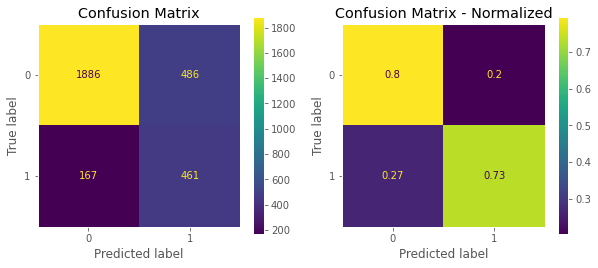

In [62]:
# matriz de confusão
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_confusion_matrix(svm, x_test_sc, y_test, ax=ax[0])
ax[0].grid(False)
ax[0].set(title='Confusion Matrix')
plot_confusion_matrix(svm, x_test_sc, y_test, normalize='true',ax=ax[1])
ax[1].grid(False)
ax[1].set(title='Confusion Matrix - Normalized');

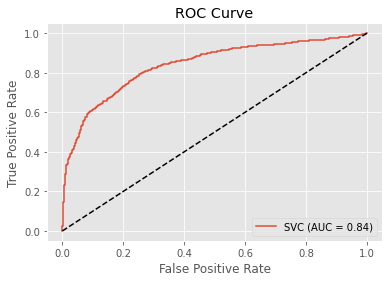

In [63]:
# curva ROC
plot_roc_curve(svm, x_test_sc, y_test)
plt.title('ROC Curve')
plt.plot(np.linspace(0,1,50), np.linspace(0,1,50), linestyle='--', color='k');

### 2.4 Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
# parâmetros para random search
max_depth = [5, 8, 10, 15]
min_samples_split = [5, 10, 50, 100]
min_samples_leaf = [10, 50, 100, 150]
n_estimators = [10, 50, 100, 150]
max_samples = [0.1, 0.2, 0.5]
params = dict(max_depth=max_depth,
              min_samples_split=min_samples_split, 
              min_samples_leaf=min_samples_leaf,
              n_estimators=n_estimators,
              max_samples=max_samples)

# classificador
clf = RandomForestClassifier(random_state=42)

# search
kfold = KFold(n_splits=10, random_state=42)
search = RandomizedSearchCV(clf, 
                            params, 
                            scoring='f1', 
                            cv=kfold,
                            verbose=1, 
                            n_jobs=-1).fit(x_train_sc, y_train)

# avaliar parâmetros
search.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished


{'n_estimators': 50,
 'min_samples_split': 100,
 'min_samples_leaf': 10,
 'max_samples': 0.5,
 'max_depth': 8}

In [77]:
# classificador
rfc = RandomForestClassifier(n_estimators=50,
                             min_samples_split=100,
                             min_samples_leaf=10,
                             max_samples=0.5,
                             max_depth=8,
                             random_state=42, n_jobs=-1)

rfc.fit(x_train_sc, y_train)

RandomForestClassifier(max_depth=8, max_samples=0.5, min_samples_leaf=10,
                       min_samples_split=100, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [78]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
rfc_results = cross_val_score(rfc, x_train_sc, y_train, cv = kfold, scoring='f1')
rfc_results.mean()

0.5090519540980546

In [79]:
# predição
rfc_predict = rfc.predict(x_test_sc)

In [80]:
# métricas
print('Precision:',precision_score(y_test, rfc_predict))
print('Recall:',recall_score(y_test, rfc_predict))
print('F1:',f1_score(y_test, rfc_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, rfc_predict))

Precision: 0.8487084870848709
Recall: 0.3662420382165605
F1: 0.8297322681027524
ROC-AUC: 0.6744785233241318


In [81]:
# matriz de confusão
rfc_cm = confusion_matrix(y_test, rfc_predict, normalize='true')
pd.DataFrame(confusion_matrix(y_test, rfc_predict))

,0,1
0,2331,41
1,398,230


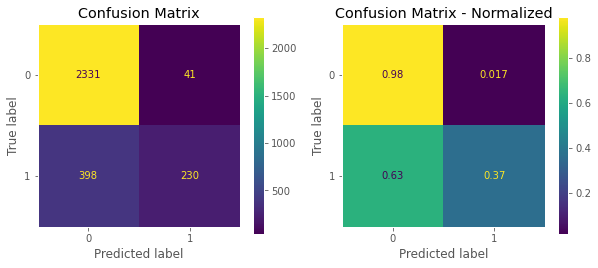

In [82]:
# matriz de confusão
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_confusion_matrix(rfc, x_test_sc, y_test, ax=ax[0])
ax[0].grid(False)
ax[0].set(title='Confusion Matrix')
plot_confusion_matrix(rfc, x_test_sc, y_test, normalize='true',ax=ax[1])
ax[1].grid(False)
ax[1].set(title='Confusion Matrix - Normalized');

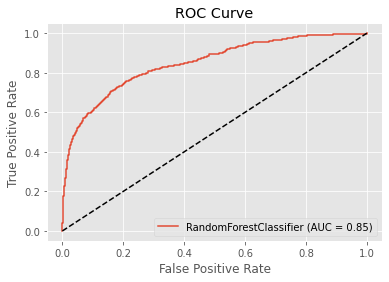

In [83]:
# curva ROC
plot_roc_curve(rfc, x_test_sc, y_test)
plt.title('ROC Curve')
plt.plot(np.linspace(0,1,50), np.linspace(0,1,50), linestyle='--', color='k');

### 2.5 Gradient Tree Boosting



In [85]:
from sklearn.ensemble import GradientBoostingClassifier

In [86]:
# parâmetros para random search
n_estimators = [50, 100, 300]
learning_rate = [0.05, 0.1, 0.2]
subsample = [0.5, 0.8, 1]
max_depth = [3, 5, 8]
min_samples_split = [50, 100, 500, 1000]
min_samples_leaf = [10, 30, 50]
params = dict(n_estimators=n_estimators, 
              learning_rate=learning_rate, 
              subsample=subsample,
              max_depth=max_depth,
              min_samples_split=min_samples_split, 
              min_samples_leaf=min_samples_leaf)

# classificador
clf = GradientBoostingClassifier(random_state=42)

# search
kfold = KFold(n_splits=10, random_state=42)
search = RandomizedSearchCV(clf, 
                            params, 
                            scoring='f1', 
                            cv=kfold,
                            verbose=1, 
                            n_jobs=-1).fit(x_train_sc, y_train)

# avaliar parâmetros
search.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.9s finished


{'subsample': 0.8,
 'n_estimators': 100,
 'min_samples_split': 500,
 'min_samples_leaf': 10,
 'max_depth': 5,
 'learning_rate': 0.1}

In [87]:
# modelo
gbc = GradientBoostingClassifier(subsample=0.8,
                                 n_estimators=100,
                                 min_samples_split=500,
                                 min_samples_leaf=10,
                                 max_depth=5,
                                 learning_rate=0.1)

gbc.fit(x_train_sc, y_train)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=10,
                           min_samples_split=500, subsample=0.8)

In [88]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
gbc_results = cross_val_score(gbc, x_train_sc, y_train, cv = kfold, scoring='f1')
gbc_results.mean()

0.5890644872546356

In [89]:
# predição
gbc_predict = gbc.predict(x_test_sc)

In [90]:
# métricas
print('Precision:',precision_score(y_test, gbc_predict))
print('Recall:',recall_score(y_test, gbc_predict))
print('F1:',f1_score(y_test, gbc_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, gbc_predict))

Precision: 0.7619047619047619
Recall: 0.5095541401273885
F1: 0.8533600365031015
ROC-AUC: 0.7336978120535761


In [91]:
# matriz de confusão
gbc_cm = confusion_matrix(y_test, gbc_predict, normalize='true')
pd.DataFrame(confusion_matrix(y_test, gbc_predict))

,0,1
0,2272,100
1,308,320


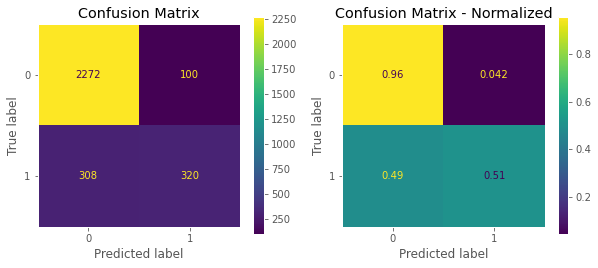

In [92]:
# matriz de confusão
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_confusion_matrix(gbc, x_test_sc, y_test, ax=ax[0])
ax[0].grid(False)
ax[0].set(title='Confusion Matrix')
plot_confusion_matrix(gbc, x_test_sc, y_test, normalize='true',ax=ax[1])
ax[1].grid(False)
ax[1].set(title='Confusion Matrix - Normalized');

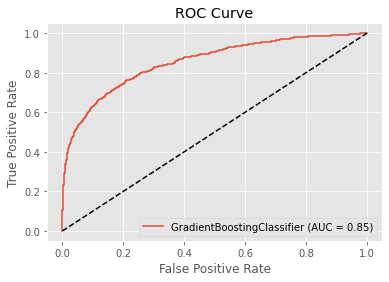

In [93]:
# curva ROC
plot_roc_curve(gbc, x_test_sc, y_test)
plt.title('ROC Curve')
plt.plot(np.linspace(0,1,50), np.linspace(0,1,50), linestyle='--', color='k');

# 3. Avaliação

Pelas figuras que apresentam a matriz de confusão abaixo, nota-se que os modelos de regressão logística e SVM apresentam uma menor taxa de FN e maior taxa de FP, resultando em um maior recall e menor precision, inverso do ocorrido nos modelos baseados em árvore.

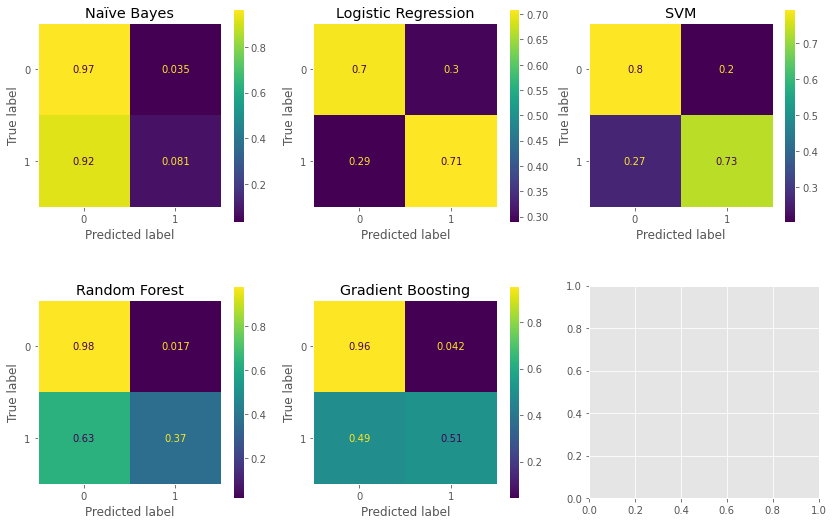

In [94]:
# confusion matrix normalized
fig, [[ax0,ax1,ax2],[ax3,ax4,ax5]] = plt.subplots(2,3,figsize=(14,9))
plot_confusion_matrix(nb, x_test, y_test, normalize='true', ax=ax0)
ax0.set(title='Naïve Bayes')
plot_confusion_matrix(lr, x_test_sc, y_test, normalize='true', ax=ax1)
ax1.set(title='Logistic Regression')
plot_confusion_matrix(svm, x_test_sc, y_test, normalize='true', ax=ax2)
ax2.set(title='SVM')
plot_confusion_matrix(rfc, x_test_sc, y_test, normalize='true', ax=ax3)
ax3.set(title='Random Forest')
plot_confusion_matrix(gbc, x_test_sc, y_test, normalize='true', ax=ax4)
ax4.set(title='Gradient Boosting')

for ax in [ax0,ax1,ax2,ax3,ax4]:
    ax.grid(False)
    
plt.subplots_adjust(hspace=0.3)

A curva ROC é uma forma gráfica de revisar o desempenho dos modelos de classificação, sendo um bom indicador de desempenho, especialmente porque estamos interessados na taxa de TP de nossos modelos. A área sob a curva (AUC) mede a capacidade do modelo de classificar corretamente aqueles que tiveram evasão, e os que não tiver. Quanto maior a AUC, melhor o classificador em relação à taxa de TP.

Abaixo, vemos que os valores de AUC para os modelos SVM, Random Forest e Gradient Boosting apresentaram performance semelhante, sendo que os últimos apresentaram o maior valor de AUC, enquanto o modelo de regressão logística ficou pouco acima do classificador utilizado como base, Naïve Bayes. Portanto, até o momento os classificadores de árvore são os melhores.

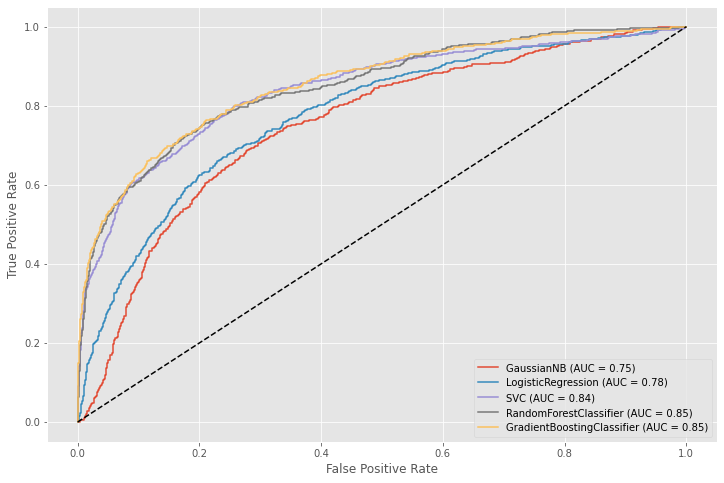

In [95]:
# ROC-AUC
fig, ax=plt.subplots(figsize=(12,8))
plot_roc_curve(nb, x_test, y_test, ax=ax)
plot_roc_curve(lr, x_test_sc, y_test, ax=ax)
plot_roc_curve(svm, x_test_sc, y_test, ax=ax)
plot_roc_curve(rfc, x_test_sc, y_test, ax=ax)
plot_roc_curve(gbc, x_test_sc, y_test, ax=ax)
ax.plot(np.linspace(0,1,50), np.linspace(0,1,50), linestyle='--', color='k');

Entretanto, quando aplicada a equação de valor esperado de lucro mencionada acima, foi possível calcular o valor esperado em função da performance dos classificadores e da matriz de custo-benefício, ou seja, considerando tanto os aspectos técnicos do classificador quanto o plano de retenção de clientes. 

Nota-se que o classficador com maior valor esperado (e único positivo) é o modelo SVM, ou seja, utilizando o plano de retenção de clientes indicado no início, o único modelo que apresentaria lucro seria o modelo SVM. Isso porque, como indicado, o modelo apresenta uma menor taxa de FN, a qual como apresentado na equação, é capaz de reduzir o valor esperado significativamente.

In [96]:
print('Naïve Bayes - Lucro Esperado: ${}'.format(
    round(
        p_1*((nb_cm[1][1]*cb[1][1]) + (nb_cm[1][0]*cb[1][0])) + 
        p_0*((nb_cm[0][0]*cb[0][0]) + (nb_cm[0][1]*cb[0][1])),
        2)
    )
)

Naïve Bayes - Lucro Esperado: $-326.22


In [97]:
print('Regressão Logística - Lucro Esperado: ${}'.format(
    round(
        p_1*((lr_cm[1][1]*cb[1][1]) + (lr_cm[1][0]*cb[1][0])) + 
        p_0*((lr_cm[0][0]*cb[0][0]) + (lr_cm[0][1]*cb[0][1])),
        2)
    )
)

Regressão Logística - Lucro Esperado: $-4.19


In [98]:
print('SVM - Lucro Esperado: ${}'.format(
    round(
        p_1*((svm_cm[1][1]*cb[1][1]) + (svm_cm[1][0]*cb[1][0])) + 
        p_0*((svm_cm[0][0]*cb[0][0]) + (svm_cm[0][1]*cb[0][1])),
        2)
    )
)

SVM - Lucro Esperado: $32.06


In [99]:
print('Random Forest - Lucro Esperado: ${}'.format(
    round(
        p_1*((rfc_cm[1][1]*cb[1][1]) + (rfc_cm[1][0]*cb[1][0])) + 
        p_0*((rfc_cm[0][0]*cb[0][0]) + (rfc_cm[0][1]*cb[0][1])),
        2)
    )
)

Random Forest - Lucro Esperado: $-147.9


In [100]:
print('Gradient Boosting - Lucro Esperado: ${}'.format(
    round(
        p_1*((gbc_cm[1][1]*cb[1][1]) + (gbc_cm[1][0]*cb[1][0])) + 
        p_0*((gbc_cm[0][0]*cb[0][0]) + (gbc_cm[0][1]*cb[0][1])),
        2)
    )
)

Gradient Boosting - Lucro Esperado: $-66.27
